# Metropolis Hastings

## Introduction

Welcome back!

Plan for today:

1.  [Markov Chains](#markov-chains)
2.  [Metropolis-Hastings explained](#metropolis-hastings)

Recap from last week:

**[What is MCMC trying to solve](mcmc_and_stan.md#MCMC)**: MCMC

## MCMC

## Markov Chains

A Markov Chain is any process that is memoryless such that

$$ p(x^{i} | x^{i-1},...,x^{1}) = p(x^{i} | x^{i-1}). $$

For example:

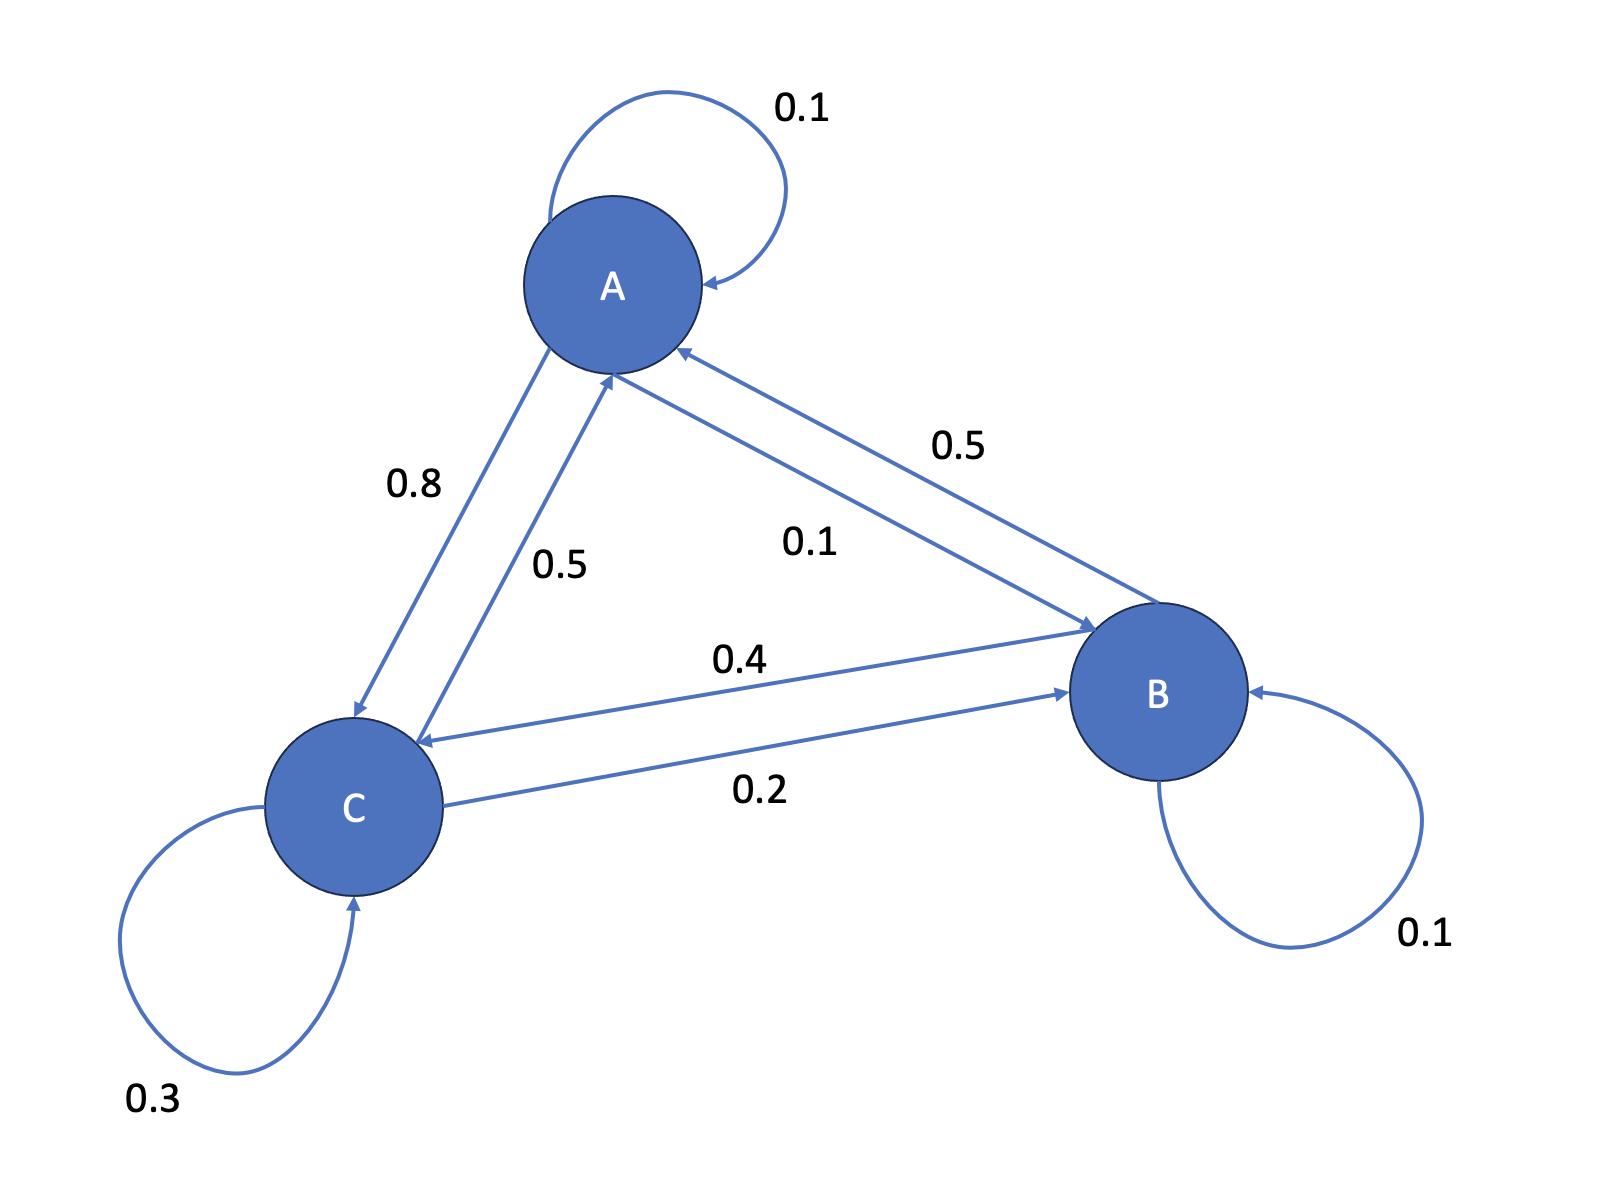

The transitions can be measured as discrete time steps with the
following matrix representation

In [1]:
import numpy as np
T = np.matrix([[0.1, 0.1, 0.8], [0.5, 0.1, 0.4], [0.5, 0.2, 0.3]])
print(T)

[[0.1 0.1 0.8]
 [0.5 0.1 0.4]
 [0.5 0.2 0.3]]

Given an initial starting position

In [2]:
v0 = np.matrix([0.1, 0.4, 0.5])
print(v0)

[[0.1 0.4 0.5]]

We can simulate the probabilities of the next step given the transition
matrix.

In [3]:
v1 = v0*T
print(v1)

[[0.46 0.15 0.39]]

Following this again we can simulate the states after two steps

In [4]:
v2 = v1*T
print(v2)

[[0.316 0.139 0.545]]

There’s a convenient way to calculate the next step given the starting
condition.

In [5]:
print(v0*T**2)

[[0.316 0.139 0.545]]

What happens if we continue doing this for a long time?

In [6]:
print(v0*T**100)

[[0.35714286 0.14935065 0.49350649]]

And how does this change when taking the next step?

In [7]:
print(v0*T**101)

[[0.35714286 0.14935065 0.49350649]]

This Markov Chain has the property of being a stationary distribution.
That satisfies the following

$$ \pi = \pi T. $$

Our objective is to estimate $\pi$, which represents the target
distribution.

**This behaviour of the Markov Chain is only satisfied if two conditions
are met.**

1.  The Markov Chain is irreducible

**Any point in the Markov chain can be reached by any other point**

1.  The Markov Chain is aperiodic **Any point can be reached by any
    other point in a single step**

## Markov Chain Monte Carlo

If we are able to draw samples from a Markov Chain that satisfies these
properties we can generate samples from the stationary proposal
distribution. After drawing samples from the sample distribution we can
investigate the quantities of interest using Monte Carlo integration
*(read: counting samples)*.

One property that is not required for a Markov Chain but satisfies the
above two properties is the detailed balance. This is not a requirement,
but it’s pretty easy to define a detailed balance rather than to define
general balance. This ensures that the Markov chain is reversible, in
other words

$$ \pi(x)*T(x'|x) = \pi(x')*T(x|x')$$.

If we define a reducible process it is defined to be irreducible and
aperiodic by default. It is a periodic because you can always go back,
and irreducible because a region cannot be entered if there is no way of
returning.

The process of generating a Markov Chain with these properties means
that we know we are sampling from a stationary target distribution, if
we have enough samples.

## Going from discrete to continuous

Rather than the previous graph networks described before we can expand
this to the continuous number line.

**Note: This isn’t always a possibility to transition between discrete
and continuous number lines, it just works out for this case**

Rather than sampling from $\pi(x)$, representing the discrete case, we
will change the notation to $p(x)$. And the transition kernel, rather
than a matrix $T(x'|x)$ will be represented by $K(x'|x).$

### Metropolis-Hastings

Metropolis-Hastings enforces the reversibility constraint using the
accept-reject function

$$
A(x,x') = min(1, \frac{p(x')g(x|x')}{p(x)g(x'|x)})
$$

and often, a symmetric proposal distribution, e.g.

$$
g(x'|x) = N(x, \sigma).
$$

The resulting kernel is represented as

$$
K(x'|x) = g(x'|x)*A(x,x').
$$

The accept-reject function, and the symmetric proposal distribution were
chosen to satisfy the detailed balance function

$$
p(x)g(x'|x)A(x,x') = p(x')g(x|x')A(x,x').
$$

Therefore, if we draw samples using the Metropolis-Hastings algorithm,
we draw samples from the target distribution $p(x)$.

## Coding the Metropolis Hastings in practice

### Part 1: sampling from a normal distribution

Given a $p(x) = N(2, 0.5)$ how would draw samples using the
Metropolis-Hastings algorithm?

1.  Choose proposal value
2.  Evaluate probability ratio
3.  Accept-Reject
4.  increment step

#### Define probability density function

In [8]:
import numpy as np
from scipy.stats import norm

def prob(x):
  return norm.pdf(x, 2, 0.5)

#### Define proposal distribution

In [9]:
def proposal(x):
  return norm.rvs(x, 1, 1)[0]

#### Initialise sampler

In [10]:
current = 0.0
samples = [current]

#### Sample from distribution

In [11]:
for i in range(10000):
    prop = proposal(current)
    accept_reject = prob(prop)/prob(current)
    if accept_reject > 1:
        samples.append(prop)
        current = prop
    else:
        cutoff = np.random.rand(1)[0]
        if accept_reject > cutoff:
            samples.append(prop)
            current = prop

#### Plot distribution

(array([   6.,   19.,  105.,  442.,  958., 1339., 1127.,  704.,  248.,
          40.]),
 array([-0.05217401,  0.30466972,  0.66151345,  1.01835718,  1.37520091,
         1.73204464,  2.08888837,  2.4457321 ,  2.80257583,  3.15941956,
         3.51626329]),
 <BarContainer object of 10 artists>)

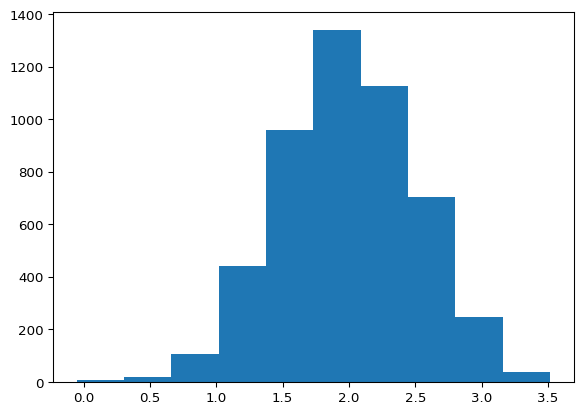

In [12]:
import matplotlib.pyplot as plt
plt.hist(samples)

#### Trace plot

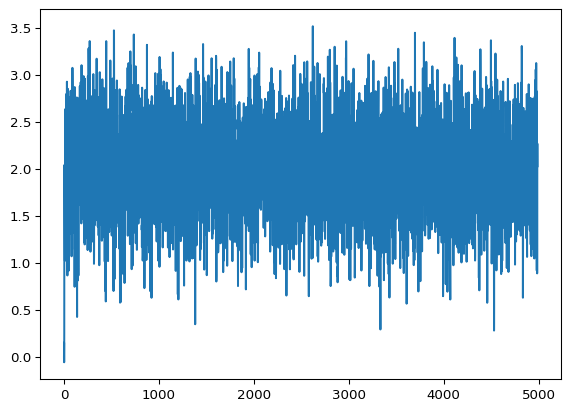

In [13]:
draw = [draw for draw, _ in enumerate(samples)]
plt.plot(draw, samples)

### Part 2: determining mean and standard deviation from data

I suggest using logs due to numerical issues. Here’s an example function
which you can use to evaluate the probability of the
[data](https://github.com/biosustain/bayesian_statistics_for_computational_biology/blob/main/data/metropolis_hastings_example.csv).

In [14]:
def eval_prob(data, mu, sigma):
    return np.log(norm.pdf(data,mu,sigma)).sum()

Here’s also a multivariate random number generator to generate
proposals.

In [15]:
def proposal_multi(mu, sigma):
    mean = [mu, sigma]
    cov = [[0.2, 0], [0, 0.2]]  # diagonal covariance
    return np.random.multivariate_normal(mean, cov, 1)[0]

Here is how you’d call the proposal function

    prop_mu, prop_sigma = proposal_multi(current_mu, current_sigma)

the accept_reject probability should also be updated to account for the
log-probability

    accept_reject = np.exp(prob_prop - prob_current)

You should sample a 95% interval including a $\mu = 5$ and a
$\sigma = 0.2$. This may be difficult at first to sample and I would
recommend initialising at these values.

## Volume in hyperspace don’t make much sense

Given an n-dimensional cube of length=2 you place spheres of diameter=1
in each of the corners and then place another sphere in the middle.

How does the size of the middle sphere change as dimensions increase?

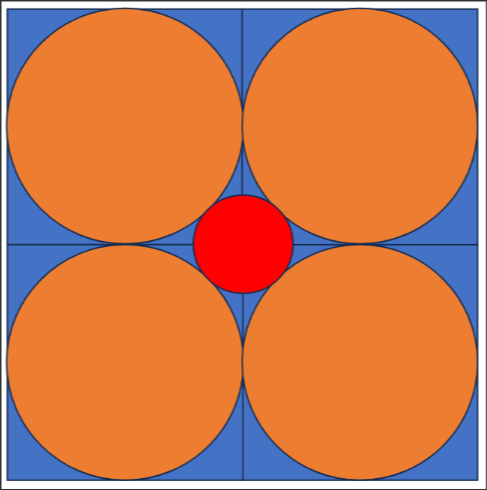

### Radius of middle sphere as dimension increases

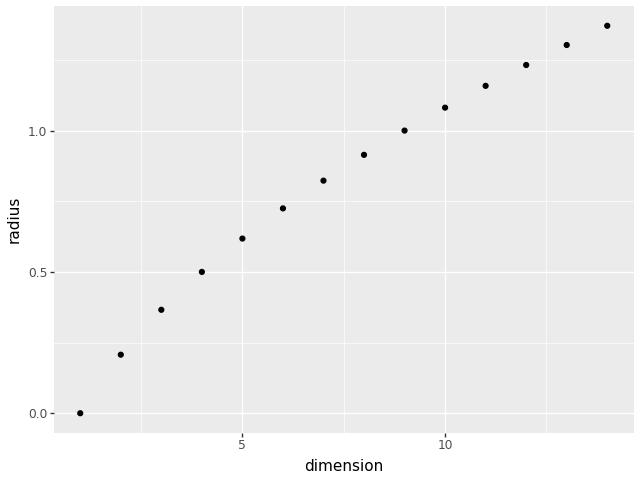